In [ ]:
# 프레임별 x,y 좌표만 추출
import csv


with open('HD_CCTV_retail_store.mp4loc_test.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    reader = list(reader)
    head_coord_rec = {i:[] for i in range(int(reader[-1][0]) + 1)}
    for row in reader:
        if int(row[1]) == 1:
            head_coord_rec[int(row[0])].append((float(row[2]), float(row[3])))
            

## 히트맵 작성

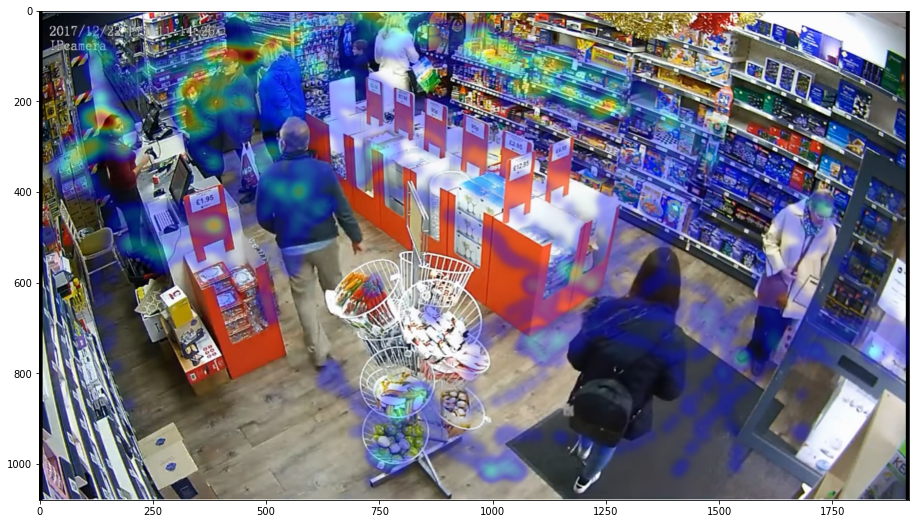

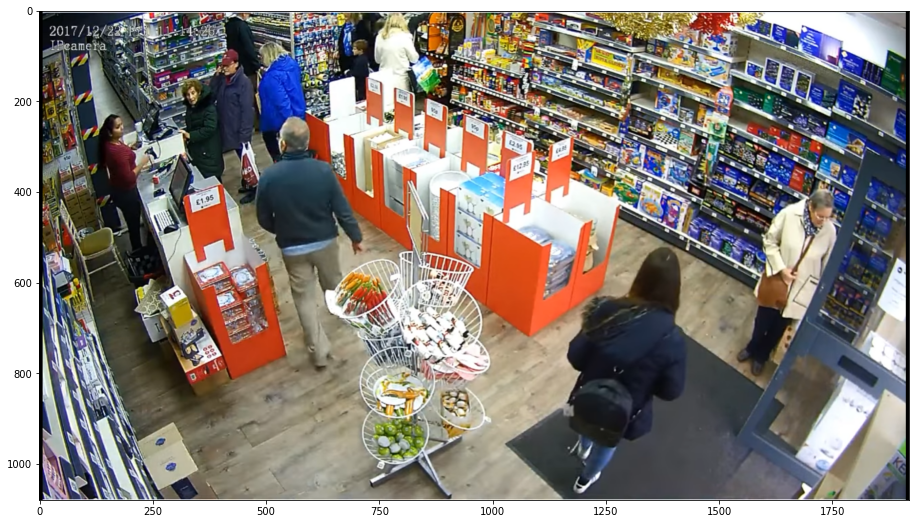

In [282]:


import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.io as io
import matplotlib.pyplot as plt
import matplotlib.cm as cm

img = io.read_image('HD_CCTV_retail_store.png') #(C, H, W)
H = img.shape[1]
W = img.shape[2]

heatmap = torch.zeros(1, H, W)
for k in head_coord_rec:
    for xy in head_coord_rec[k]:
        x, y = round(xy[0] * W), round(xy[1] * H)
        heatmap[0][y][x] += 1
        
heatmap = transforms.GaussianBlur(101, sigma=10)(heatmap)
heatmap = heatmap ** 0.4

heatmap = heatmap.permute(1, 2, 0)
heatmap /= heatmap.max()

heat_mag = torch.cat([heatmap]*3, dim=2).numpy()
heat_mag = 1 / (1 +np.exp(-50*heat_mag+3.5))
heatmap = (heatmap * 255).to(torch.uint8)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap.reshape(H, W)]

img = img.permute(1, 2, 0).numpy()

alpha = 0.4

superimposed_img = jet_heatmap * 255 * alpha * heat_mag + img * (1-alpha * heat_mag)
superimposed_img = superimposed_img.astype(np.uint8)

plt.figure(1, figsize=[16, 9])
plt.imshow(superimposed_img)
plt.figure(2, figsize=[16, 9])
plt.imshow(img)

## 히트맵 평면화

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('./heatmap05.png')
# [x,y] 좌표점을 4x2의 행렬로 작성
# 좌표점은 좌상->좌하->우상->우하
pts1 = np.float32([[383,1],[351,963],[721,1],[805,963]])

# 좌표의 이동점
pts2 = np.float32([[250,0],[300,1000],[900,0],[850,1000]])

M = cv2.getPerspectiveTransform(pts1, pts2)

dst = cv2.warpPerspective(img, M, (1100,1100))

plt.figure(figsize=(20,30))
plt.subplot(121),plt.imshow(img),plt.title('image')
plt.subplot(122),plt.imshow(dst),plt.title('Perspective')
plt.show()